<a href="https://colab.research.google.com/github/learningdollars/dafa-reddit-visualization-and-analytic/blob/master/Reddit_Visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reddit Conversation Data Analytics & Visualization with ...

<!-- wp:paragraph -->
<p>Politic subreddit.</p>
<!-- /wp:paragraph -->

<!-- wp:paragraph -->
<p>Simple:</p>
<!-- /wp:paragraph -->

<!-- wp:list -->
<ul><li>Time vs upvote.</li><li>Upvote vs downvote words correlation.</li></ul>
<!-- /wp:list -->

<!-- wp:paragraph -->
<p>Relations:</p>
<!-- /wp:paragraph -->

<!-- wp:list -->
<ul><li>Post =&gt; Comments.</li><li>Comment =&gt; Comments.</li><li>Conversation depth based on the comment length.</li><li>Common words reply to positive (P) vs controversial (N) comments:<ul><li>N &gt; N | N &gt; P | P &gt; P | P &gt; N</li><li>Sankey</li></ul></li><li>N reply vs time after comment. Compare top vs controversial.</li></ul>
<!-- /wp:list -->

## Initialization

Load data from Google Drive

In [0]:
# Install update and some other packages
!apt-get update
!pip install anytree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit

In [0]:
import anytree
from anytree import NodeMixin, Node, RenderTree, PreOrderIter

# Custom anytree node for posts' comments
class NodeCom(NodeMixin):
  def __init__(self, name, attrs=None, parent=None, children=None):
    super(NodeCom, self).__init__()
    self.name = name
    self.attrs = attrs  # The reddit data
    self.parent = parent
    if children:
      self.children = children

In [0]:
# Use pickle for file-variable management
import pickle

# Mount Google Drive as folder in "/drive" Collab folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#@title Drive Mount { form-width: "30%" }
FILE = "save_politic.dat" #@param {type:"string"}

# Load data and place it in working directory "content/"
copy_cmd = "/content/drive/My\ Drive/"+FILE+" "+"/content/"
!cp $copy_cmd

with open(FILE, 'rb') as f:
    loaded = pickle.load(f)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Preview tree of a single post
view = loaded[0]
# print(RenderTree(prev["comments"])) # Print the contents as tree of objects
print()
for pre, fill, node in RenderTree(view["comments"]):
  vote = node.attrs["data-score"]
  if vote == None:
    vote = 0

  treestr = u"%s%d" % (pre, vote)
  # Preview the text cropped, and newline removed
  print(treestr.ljust(8), node.attrs["text"][:50].replace('\n', ' '))


96741    The FBI Just Put White Nationalists and Neo-Nazis 
├── 0    As a reminder, this subreddit is for civil discuss
├── 8054  Citing Justice Department sources, CBS reports th
│   ├── 3414 Steve Bannon?  
│   │   ├── 1296 Go on...  
│   │   │   ├── 2151 Stephen Miller, White House Senoir Policy Adviser.
│   │   │   │   ├── 885 Yeah, that's the good stuff right there. Maybe spi
│   │   │   │   │   ├── 668 Matt Shea belongs on that list.  
│   │   │   │   │   │   ├── 300 Abso-fucking-lutely. That psycho was actually prep
│   │   │   │   │   │   │   ├── 302 Speaking of holy war, Erik Prince, anyone?  
│   │   │   │   │   │   │   │   ├── 119 He's being held in reserve for when Trump tries to
│   │   │   │   │   │   │   │   └── 49 ...no. No thank you, none for me, thanks.  
│   │   │   │   │   │   │   └── 109 was?  Did he stop?  He's still in office, right?  
│   │   │   │   │   │   │       └── 104 I had to go back to look, because I thought he was
│   │   │   │   │   │   │           ├

In [0]:
# Simple example for accessing individual data
t_post = loaded[4] # Getting certain post
t_comments = t_post["comments"].children # Getting its comments
t_comments[1].attrs # View a comment & its attributes
print(t_comments[1].attrs["text"]) # View a comment's text
print(t_comments[1].children)  # View the replies of a main comment

Yeah that’s all well and good but what about people’s right to choose to go bankrupt and die?


(<__main__.NodeCom object at 0x7f05bb210c88>, <__main__.NodeCom object at 0x7f05bb215240>, <__main__.NodeCom object at 0x7f05bb2155c0>, <__main__.NodeCom object at 0x7f05bb215780>, <__main__.NodeCom object at 0x7f05bb215940>, <__main__.NodeCom object at 0x7f05bb215b00>, <__main__.NodeCom object at 0x7f05bb215cc0>)


In [0]:
# Convert to pandas dataframe for ease of access for visualization not requiring relational data
# This will get the posts, as they're the heads of the comments.
# Accessing the comments tree object must be done from each individual posts like above example.
df = pd.DataFrame(loaded)
df[0:3]

,class,id,onclick,data-fullname,data-type,data-gildings,data-whitelist-status,data-author,data-author-fullname,data-subreddit,data-subreddit-prefixed,data-subreddit-fullname,data-subreddit-type,data-timestamp,data-url,data-permalink,data-domain,data-rank,data-comments-count,data-score,data-promoted,data-nsfw,data-spoiler,data-oc,data-num-crossposts,data-context,text,comments,data-crosspost-root-title,data-crosspost-root-score,data-crosspost-root-num-comments,data-crosspost-root-author,data-crosspost-root-subreddit,data-crosspost-root-subreddit-prefixed,data-crosspost-root-time,data-target-parent-fullname,data-target-root-fullname,data-target-root-type
0,"[, thing, id-t3_ezxd7e, odd, gilded, link, ]",thing_t3_ezxd7e,click_thing(this),t3_ezxd7e,link,3,all_ads,N0tAG00dUserName,t2_jdlky6b,politics,r/politics,t5_2cneq,public,1581016827000,https://www.vice.com/en_us/article/3a8awn/the-...,/r/politics/comments/ezxd7e/the_fbi_just_put_w...,vice.com,1,5244,96741,false,false,false,false,33,listing,The FBI Just Put White Nationalists and Neo-Na...,<__main__.NodeCom object at 0x7f05bbbea080>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[, thing, id-t3_f0b9k8, even, gilded, link, ]",thing_t3_f0b9k8,click_thing(this),t3_f0b9k8,link,1,all_ads,nnnarbz,t2_t22xckq,politics,r/politics,t5_2cneq,public,1581086015000,https://www.cnn.com/2020/02/07/politics/virgin...,/r/politics/comments/f0b9k8/virginia_will_elim...,cnn.com,2,5328,93243,false,false,false,false,19,listing,Virginia will eliminate a state holiday honori...,<__main__.NodeCom object at 0x7f05bb371e80>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[, thing, id-t3_f1eqc4, odd, gilded, link, ]",thing_t3_f1eqc4,click_thing(this),t3_f1eqc4,link,5,all_ads,nnnarbz,t2_t22xckq,politics,r/politics,t5_2cneq,public,1581280879000,https://www.marketwatch.com/story/bernie-sande...,/r/politics/comments/f1eqc4/bernie_sanders_pre...,marketwatch.com,3,3978,81877,false,false,false,false,15,listing,Bernie Sanders: “President Trump is a socialis...,<__main__.NodeCom object at 0x7f05bb2f9f98>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Simple Statistics

Simple data exploration that doesn't make use of the content of the data, just the attributes.

### Upvote vs Time

In [0]:
# Add a new columns for real date & weekday (UTC, offset for another timezone)
df["date"] = df["data-timestamp"].astype("int64").astype("datetime64[ms]")
df["day"] = df["date"].dt.weekday
day = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]

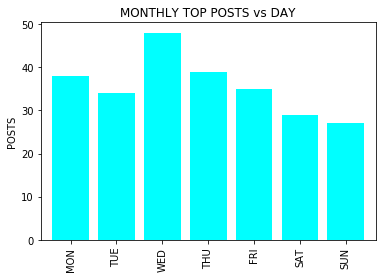

In [0]:
## N of posts in the monthly top 250 vs time
# Based on the day of the week
plt.rcParams["figure.figsize"] = (6,4)
ax = df["day"].groupby(df["day"]).count().plot(kind="bar", width=0.8)
ax.set(xlabel="", ylabel="POSTS", title="MONTHLY TOP POSTS vs DAY")
plt.xticks(range(7), day)
plt.show()

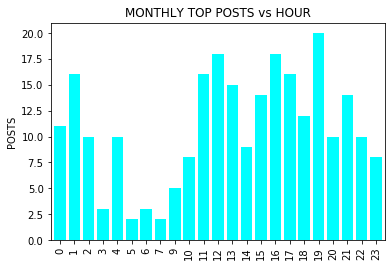

In [0]:
# Based on the time of the day
ax = df["date"].groupby(df["date"].dt.hour).count().plot(kind="bar", colormap="cool", width=0.8)
ax.set(xlabel="", ylabel="POSTS", title="MONTHLY TOP POSTS vs HOUR") # Default is UTC
plt.show()

Upvote range: 17701 131985


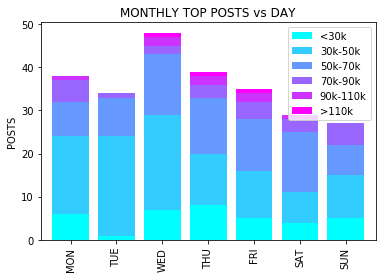

In [0]:
# Based on the day of the week, but segmented into upvote count groups
minscr = df["data-score"].min()
maxscr = df["data-score"].max()
print("Upvote range:", minscr, maxscr)

# Manually determine certain segmentation
dfseg = pd.DataFrame(index=range(7), columns=[])
dfseg["<30k"] = df[df["data-score"]<=30000]["day"].groupby(df["day"]).count()
dfseg["30k-50k"] = df[(df["data-score"]>30000) & (df["data-score"]<=50000)]["day"].groupby(df["day"]).count()
dfseg["50k-70k"] = df[(df["data-score"]>50000) & (df["data-score"]<=70000)]["day"].groupby(df["day"]).count()
dfseg["70k-90k"] = df[(df["data-score"]>70000) & (df["data-score"]<=90000)]["day"].groupby(df["day"]).count()
dfseg["90k-110k"] = df[(df["data-score"]>90000) & (df["data-score"]<=110000)]["day"].groupby(df["day"]).count()
dfseg[">110k"] = df[df["data-score"]>110000]["day"].groupby(df["day"]).count()

ax = dfseg.plot(kind="bar", stacked=True, colormap="cool", width=0.8)
ax.set(xlabel="", ylabel="POSTS", title="MONTHLY TOP POSTS vs DAY")
plt.xticks(range(7), day)
plt.show()

### Upvote vs Comment location

In [0]:
# Upvote vs the further down the comment
# Even reply of the reply to the top 1st comment is going to be higher than the top 2nd comment
verts = []                      # The score in vertical-wise order
for post in loaded:
  cmts = []
  # Unpack the tree into a single array
  for cmt in PreOrderIter(post["comments"], maxlevel=4):
    # Maxlevel determine how deep do you want to look relative to current node
    # Maxlevel 1 = the post itself, 2 = Main comments, 3 = replies to the main comments, etc
    
    score = cmt.attrs["data-score"]
    if score != None:
      cmts.append(score)
      
  verts.append(cmts[1:]) # Skip the first one coz it's the post, not the comment

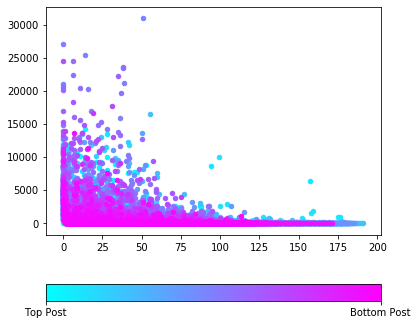

In [0]:
# Scatter
plt.rcParams["figure.figsize"] = (6,6)
n_post = 256  # N of posts to be included
for i, vert in enumerate(verts[0:n_post]):
  # The colormap value (0, 256) is normalized across the whole posts (0, n_post)
  plt.scatter(range(len(vert)), vert, color=cm.cool(i*int(256.0/n_post)), s=20)

plt.set_cmap("cool")
cbar = plt.colorbar(orientation = "horizontal", ticks=[0, 1])
cbar.ax.set_xticklabels(['Top Post', 'Bottom Post'])

plt.show()

In [0]:
# # Normalized to max
# n_post = 256  # N of posts to be included
# for i, vert in enumerate(verts[0:n_post]):
#   # Normalize every comment in a posts to the max upvote
#   norm = [float(i)/max(vert) for i in vert]
#   # The colormap value (0, 256) is normalized across the whole posts (0, n_post)
#   plt.scatter(range(len(norm)), norm, color=cm.cool(i*int(256.0/n_post)))
#   # plt.yscale('log')

# plt.set_cmap("cool_r")
# cbar = plt.colorbar(ticks=[0, 1])
# cbar.ax.set_yticklabels(['Bottom', 'Top'])

# plt.show()

In [0]:
# Add trendline by combining them all (maintining comment index)
comb_n = []
comb_i = []
n_post = 256  # N of posts to be included
for vert in verts[0:n_post]:
  idx = range(len(vert))
  comb_n.extend(vert)
  comb_i.extend(idx)

# Model used for exponential decay fit
def model_func(x, a, k, b):
    return a * np.exp(-k*x) + b

# Curve fit
p0 = (1.,1.e-5,1.) # Starting search koefs
opt, pcov = curve_fit(model_func, comb_i, comb_n, p0)
a, k, b = opt

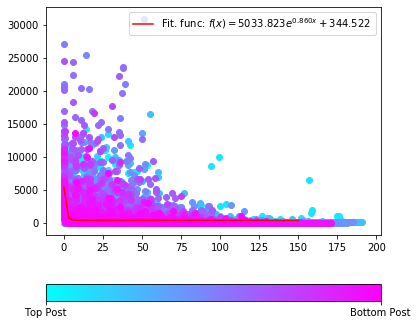

In [0]:
# Main plot
for i, vert in enumerate(verts[0:n_post]):
  # The colormap value (0, 256) is normalized across the whole posts (0, n_post)
  plt.scatter(range(len(vert)), vert, color=cm.cool(i*int(256.0/n_post)))

plt.set_cmap("cool")
cbar = plt.colorbar(orientation = "horizontal", ticks=[0, 1])
cbar.ax.set_xticklabels(['Top Post', 'Bottom Post'])

# Showing the curve fit
x2 = np.linspace(0, 150, 50)
y2 = model_func(x2, a, k, b)
plt.plot(x2, y2, color='r', label='Fit. func: $f(x) = %.3f e^{%.3f x} %+.3f$' % (a,k,b))
plt.legend(loc='best')

plt.show()

### Replies vs Comment location

In [0]:
# Main comments' replies vs the further down the comment
verts = [] # The replies in vertical-wise order
for post in loaded:
  cmts = []
  
  # Unpack the tree into a single array
  for cmt in PreOrderIter(post["comments"], maxlevel=2):
    # We want to get only the main comments here, thus maxlevel=2

    child = 0
    for reply in PreOrderIter(cmt, maxlevel=4):
      # We want to get the reply chain to the main comments
      child += 1
    cmts.append(child)
    
  verts.append(cmts[1:]) # Skip the first one coz it's the post, not the comment

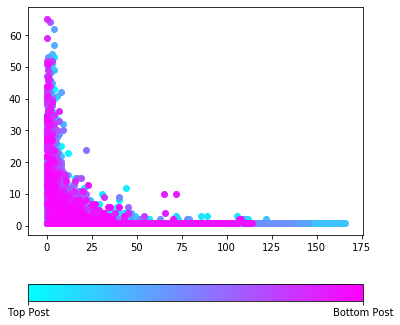

In [0]:
# Scatter
n_post = 256  # N of posts to be included
for i, vert in enumerate(verts[0:n_post]):
  # The colormap value (0, 256) is normalized across the whole posts (0, n_post)
  plt.scatter(range(len(vert)), vert, color=cm.cool(i*int(256.0/n_post)))

plt.set_cmap("cool")
cbar = plt.colorbar(orientation = "horizontal", ticks=[0, 1])
cbar.ax.set_xticklabels(['Top Post', 'Bottom Post'])

plt.show()

In [0]:
# Add trendline by combining them all (maintining comment index)
comb_n = []
comb_i = []
n_post = 256  # N of posts to be included
for vert in verts[0:n_post]:
  idx = range(len(vert))
  comb_n.extend(vert)
  comb_i.extend(idx)

# Model used for exponential decay fit
def model_func(x, a, k, b):
    return a * np.exp(-k*x) + b

# Curve fit
p0 = (1.,1.e-5,1.) # Starting search koefs
opt, pcov = curve_fit(model_func, comb_i, comb_n, p0)
a, k, b = opt

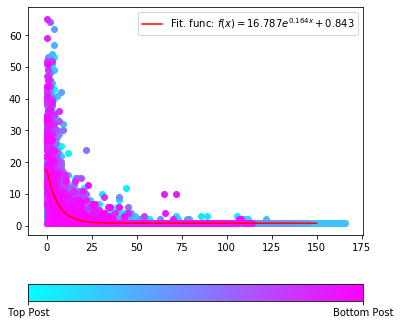

In [0]:
# Main plot
for i, vert in enumerate(verts[0:n_post]):
  # The colormap value (0, 256) is normalized across the whole posts (0, n_post)
  plt.scatter(range(len(vert)), vert, color=cm.cool(i*int(256.0/n_post)))

plt.set_cmap("cool")
cbar = plt.colorbar(orientation = "horizontal", ticks=[0, 1])
cbar.ax.set_xticklabels(['Top Post', 'Bottom Post'])

# Showing the curve fit
x2 = np.linspace(0, 150, 50)
y2 = model_func(x2, a, k, b)
plt.plot(x2, y2, color='r', label='Fit. func: $f(x) = %.3f e^{%.3f x} %+.3f$' % (a,k,b))
plt.legend(loc='best')

plt.show()

In [0]:
# # Getting the comments score fraction compared to their parent comment
# t_post = loaded[0] # Getting certain post
# t_comments = t_post["comments"].children # Getting its comments

# sent = [] # Sentimentality
# for cmt in t_comments:
#   print(cmt.attrs["data-score"])
#   for cmt1 in cmt.children:
#     print("", cmt1.attrs["data-score"])
#     for cmt2 in cmt1.children:
#       print(" ", cmt2.attrs["data-score"])

## Complex Statistics

A more complex data exploration that makes use of the content of the data.

### Important Words

In [0]:
# Common post title words
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:20]
freq

the        134
to         130
of         102
Trump       81
in          78
a           59
and         49
for         45
on          40
is          38
Sanders     30
as          25
The         24
by          22
Bernie      21
that        21
he          20
it          18
after       18
from        18
dtype: int64

In [0]:
# Uncommon post title words
freq =  pd.Series(' '.join(df['text']).split()).value_counts()[-20:]
freq

acquit           1
temperatures     1
Full             1
PM               1
line             1
proposes         1
water-bombing    1
millionaires     1
inmates          1
afterwards,      1
protections      1
Play             1
horrific’:       1
50,000           1
contributions    1
breaking         1
fewer            1
specialist       1
Party.           1
Saves            1
dtype: int64

In [0]:
# Get every post & comment as an array
content = []
for post in loaded:
  content.extend([node.attrs["text"] for node in PreOrderIter(post["comments"], maxlevel=6)])
content[0:20]

['The FBI Just Put White Nationalists and Neo-Nazis on the Same Threat Level as ISIS',
 "As a reminder, this subreddit is for civil discussion.\nIn general, be courteous to others. Debate/discuss/argue the merits of ideas, don't attack people. Personal insults, shill or troll accusations, hate speech, any advocating or wishing death/physical harm, and other rule violations can result in a permanent ban. \nIf you see comments in violation of our rules, please report them.\nFor those who have questions regarding any media outlets being posted on this subreddit, please click here to review our details as to whitelist and outlet criteria.\n\nI am a bot, and this action was performed automatically. Please contact the moderators of this subreddit if you have any questions or concerns.\n\n",
 '\nCiting Justice Department sources, CBS reports that more federal arrests targeting neo-Nazi or white nationalists are coming down the pike, including people with ties to networks in Europe, Ukraine, a

In [0]:
# Libraries for text preprocessing
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag

# Stopwords: Stop words include the large number of prepositions, pronouns, conjunctions etc in sentences.
# Normalization (Stemming & lemmatization): Convert to base word, ex: 
# learn, learned, learning, learner will be converted to "learn"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:
# Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))

# Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

In [0]:
corpus = []
for sentence in content:
    # Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # Remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    # Convert to list from string
    text = text.split()
    
    # Stemming
    ps=PorterStemmer()
    # Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [0]:
# View an item from the corpus
corpus[2]

'citing justice department source cbs report federal arrest targeting neo nazi white nationalist coming pike including people tie network europe ukraine russia'

### Word Cloud

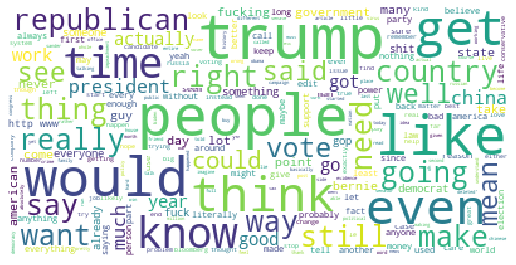

In [0]:
# Word cloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

plt.rcParams["figure.figsize"] = (9,9)
wordcloud = WordCloud(    background_color='white',
                          stopwords=stop_words,
                          max_words=400,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
                         
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [0]:
# Removing everything except Noun
# Using part-of-speech (POS) tagging:
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

corpus2 = []
for sentence in corpus:
  words = sentence.split()
  tagged = pos_tag(words)

  # Only get the ones with N** tagging
  nouns = [s[0] for s in tagged if s[1][0] == 'N']

  # Revert back the array of words into a sentence
  corpus2.append(' '.join(nouns))

In [0]:
# View an item from the corpus
print(corpus[2])
print(corpus2[2])

citing justice department source cbs report federal arrest targeting neo nazi white nationalist coming pike including people tie network europe ukraine russia
justice department source cbs report arrest nationalist people network ukraine russia


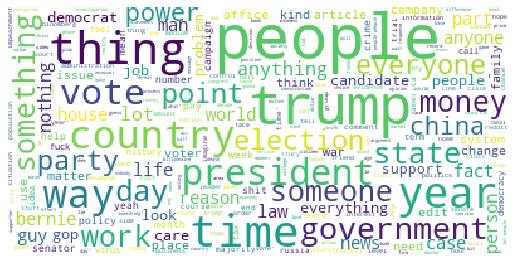

In [0]:
# Word cloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

plt.rcParams["figure.figsize"] = (9,9)
wordcloud = WordCloud(    background_color='white',
                          max_words=400,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus2))
                         
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()